# Loading Dataset

In [179]:
from glob import glob
from keras.utils import np_utils
from sklearn.datasets import load_files
import numpy as np


def load_dataset(path):
    data = load_files(path)
    bones_files = np.array(data['filenames'])
    bones_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return bones_files, bones_targets


names = [item[20:-1] for item in sorted(glob("images/bones/train/*/"))]
train_files, train_targets = load_dataset('images/bones/train')
valid_files, valid_targets = load_dataset('images/bones/valid')
test_files, test_targets = load_dataset('images/bones/test')

print('There are %d total bone disease categories.' % len(names))
print('There are %s total bone images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training bone images.' % len(train_files))
print('There are %d validation bone images.' % len(valid_files))
print('There are %d test bone images.'% len(test_files))


There are 3 total bone disease categories.
There are 304 total bone images.

There are 256 training bone images.
There are 24 validation bone images.
There are 24 test bone images.


# Loading Tensors

In [180]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


# Pre-processing Images

In [181]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|██████████| 24/24 [00:00<00:00, 190.87it/s]


# Creating CNN Model

In [182]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(3, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 28, 28, 64)        0         
__________

# Training The Model

In [187]:
from keras.callbacks import ModelCheckpoint

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 256 samples, validate on 24 samples
Epoch 1/10
256/256 [==============================] - 7s - loss: 1.0616 - acc: 0.4336 - val_loss: 1.0223 - val_acc: 0.5417
Epoch 2/10
256/256 [==============================] - 7s - loss: 1.0364 - acc: 0.4531 - val_loss: 0.9890 - val_acc: 0.5417
Epoch 3/10
256/256 [==============================] - 7s - loss: 1.0587 - acc: 0.4375 - val_loss: 1.0091 - val_acc: 0.5000
Epoch 4/10
256/256 [==============================] - 7s - loss: 1.0180 - acc: 0.4766 - val_loss: 0.9883 - val_acc: 0.5833
Epoch 5/10
256/256 [==============================] - 7s - loss: 1.0073 - acc: 0.4766 - val_loss: 0.9343 - val_acc: 0.5833
Epoch 6/10
256/256 [==============================] - 7s - loss: 1.0391 - acc: 0.4766 - val_loss: 0.9506 - val_acc: 0.6250
Epoch 7/10
256/256 [==============================] - 7s - loss: 1.0138 - acc: 0.4687 - val_loss: 0.9703 - val_acc: 0.5833
Epoch 8/10
256/256 [==============================] - 7s - loss: 1.0083 - acc: 0.4609 - val_lo

# Testing The Model

In [188]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Bones test accuracy: %.4f%%' % test_accuracy)


Bones test accuracy: 41.6667%


# Prediction Machine

In [191]:

categories = {
    0: 'Fracture',
    1: 'Osteomyelitis',
    2: 'Osteochondroma'
}

def prediction_machine(img_path):
    tensor = path_to_tensor(img_path)

    prediction_array = model.predict(tensor)
    print(prediction_array)
    prediction = np.argmax(prediction_array)
    return categories[prediction]


# Bone Disease Diagnose

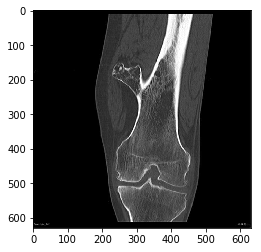

images/bones/final/osteochondroma_final.jpg
[[ 0.32304844  0.34299514  0.33395642]]
Predicted Disease: Osteomyelitis


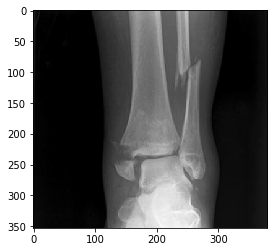

images/bones/final/fracture_final_2.jpg
[[ 0.32304844  0.34299514  0.33395642]]
Predicted Disease: Osteomyelitis


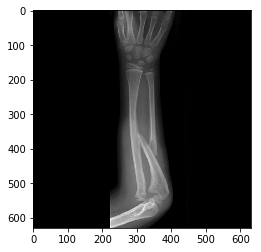

images/bones/final/fracture_final_1.jpg
[[ 0.32304844  0.34299514  0.33395642]]
Predicted Disease: Osteomyelitis


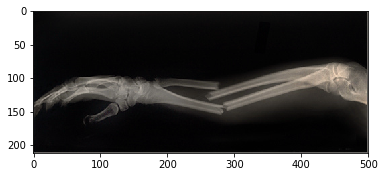

images/bones/final/fracture_final_4.jpg
[[ 1.  0.  0.]]
Predicted Disease: Fracture


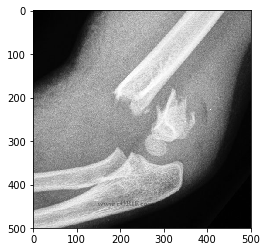

images/bones/final/fracture_final_3.jpg
[[ 1.  0.  0.]]
Predicted Disease: Fracture


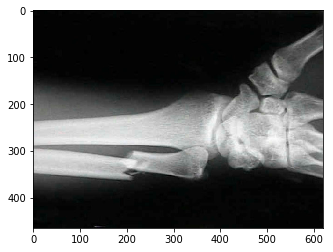

images/bones/final/fracture_final.jpg
[[ 1.  0.  0.]]
Predicted Disease: Fracture


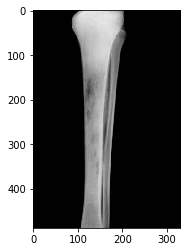

images/bones/final/osteomelytis_final.jpg
[[ 0.32304844  0.34299514  0.33395642]]
Predicted Disease: Osteomyelitis


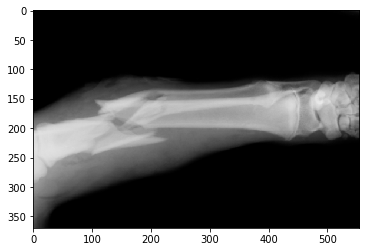

images/bones/final/fracture_final_5.png
[[ 1.  0.  0.]]
Predicted Disease: Fracture


In [216]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline


final_images = np.array(glob('images/bones/final/*'))

for img_path in final_images:
    p_img = cv2.imread(img_path)
    p_img_gray = cv2.cvtColor(p_img, cv2.COLOR_BGR2GRAY)
    plt.imshow(p_img)
    plt.show()
    print(img_path)
    prediction = prediction_machine(img_path)
    print('Predicted Disease: {0}'.format(prediction))


# Using Transfer Learning

# Loading Bottleneck Features

In [217]:
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
bf_train = bottleneck_features['train']
bf_valid = bottleneck_features['valid']
bf_test = bottleneck_features['test']
print(bf_train.size)
print(bf_valid.size)
print(bf_test.size)

670351360
83793920
83894272


# Adding Extra Layers to Transfered Model

In [218]:
bf_model = Sequential()
bf_model.add(GlobalAveragePooling2D(input_shape=bf_train.shape[1:]))
bf_model.add(Dense(3, activation='softmax'))
bf_model.summary()
bf_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 3)                 6147      
Total params: 6,147.0
Trainable params: 6,147.0
Non-trainable params: 0.0
_________________________________________________________________


# Training Transfered Model

In [219]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5',
                               verbose=1, save_best_only=True)

bf_model.fit(bf_train, train_targets, validation_data=(bf_valid, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

ValueError: Input arrays should have the same number of samples as target arrays. Found 6680 input samples and 256 target samples.